In [13]:
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.linear_model import LinearRegression as lm

embed = lambda x, d : np.hstack([x.shift(i) for i in range(d)])[d - 1:] # R's embed(x, d)

In [236]:
def runAR(window, indice, lag, type="fixed"):
    
    Y = window.iloc[:, [indice]]  # DataFrame
    aux = embed(Y, lag + 4)
    y = aux[:, 0]
    X = np.delete(aux, range(Y.shape[1]*lag), axis=1)

    if lag == 1:
        out = aux[-1, :X.shape[1]]
    else:
        out = np.delete(aux, range(Y.shape[1]*(lag-1)), axis=1)
        out = out[-1, :X.shape[1]]

    y = y[:y.shape[0]-lag+1]
    X = X[:y.shape[0]-lag+1]
    cX = add_constant(X, prepend=True)

    if type == "fixed":
        model = OLS(y, cX).fit()
        coef = model.params

    if type == "bic":
        bb = np.inf
        for i in range(X.shape[1]):
            m = OLS(y, add_constant(X[:, i+1], prepend=True)).fit()
            crit = m.bic
            if crit < bb:
                bb = crit
                model = m
                coef = model.params

    # append zeros to coef such that len(coef) == number of col. in cX
    coef = np.pad(coef, (0, (cX.shape[1]-len(coef))), 'constant', constant_values=0)            
    pred = np.concatenate(([1], out), axis=0).dot(coef)
    
    return model, pred, coef


def ar_rolling_window(Y, nprev, indice=0, lag=1, type="fixed"):
    coef = np.empty((nprev, 5))*np.nan
    pred = np.empty(nprev)*np.nan

    for i in range(nprev):
        window = Y.iloc[i:len(Y)-(nprev-i)] # The last obs. is not inclued in the last iter.
        model, pred[i], coef[i] = runAR(window, indice, lag)
        #print(f"iteration {i}\n")

    real = Y.iloc[:, 0]
    
    fig, ax = plt.subplots(1,1,figsize=(12, 6))
    real.plot(ax=ax)
    ax.plot(real.index, np.concatenate((np.empty(len(Y)-nprev)*np.nan, pred.squeeze())))

    rmse = np.sqrt(np.mean((real.iloc[-nprev:] - pred)**2))
    mae = np.mean(np.abs(real.iloc[-nprev:] - pred))
    errors = {'rmse':rmse, 'mae':mae}

    return {'pred':pred, 'coef':coef, 'errors':errors}

In [290]:
result = pyreadr.read_r('rawdata.rda')

Y = result['dados']

nprev=132

In [291]:
indice = 0
lag    = 1
type   = "fixed"

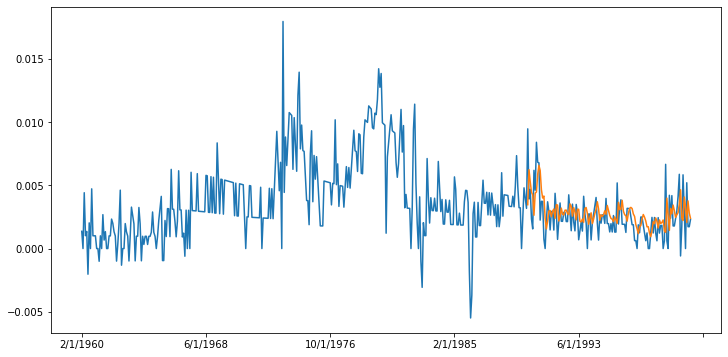

In [292]:
ar1 = ar_rolling_window(Y, nprev, indice, lag, type)

In [293]:
ar1

{'pred': array([0.00346267, 0.00623047, 0.00528282, 0.00445201, 0.00423607,
        0.00262993, 0.00437474, 0.00446507, 0.00585332, 0.00656755,
        0.00616992, 0.00463997, 0.00399245, 0.00414707, 0.00239952,
        0.00155321, 0.00219371, 0.00296401, 0.00300166, 0.00252636,
        0.00295596, 0.00312056, 0.00238704, 0.00346371, 0.00343621,
        0.00217472, 0.00255803, 0.00319329, 0.00271291, 0.00265055,
        0.00303146, 0.00303561, 0.00276802, 0.00267771, 0.00352652,
        0.00334347, 0.0025559 , 0.00323205, 0.00288673, 0.0022632 ,
        0.00309948, 0.00310403, 0.00215568, 0.00210627, 0.00232966,
        0.00207225, 0.00316583, 0.0032413 , 0.00277257, 0.00191865,
        0.00240994, 0.00282336, 0.00197213, 0.00232685, 0.0027544 ,
        0.00309095, 0.00369588, 0.00312935, 0.0022323 , 0.00267013,
        0.00254423, 0.00267348, 0.00297838, 0.00270541, 0.00340299,
        0.00300896, 0.00261813, 0.00238059, 0.00231655, 0.00212622,
        0.00249896, 0.00227443, 0.001996